# Part 1: Equivalent circuit network modelling of a lithium ion barrtey - Thevenin Model

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tools import *

## Load data

In [3]:
data_dir = os.path.abspath('battery_experimental_data')
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')
testing_data = pd.read_csv(os.path.join(data_dir, 'Battery_Testing_Data.csv'), header=0, skiprows=[1])

display(SOC_OCV_data.head())
display(testing_data.head())

,SOC,Ecell/V
0,100.000000,4.186240
1,99.998926,4.186390
2,99.997852,4.186268
3,99.996778,4.186108
4,99.995704,4.186100


,Time (s),Current (mA),Voltage (V),Temperature
0,1,0.0,4.05,21.96
1,2,0.0,4.05,21.94
2,3,0.0,4.05,21.94
3,4,0.0,4.05,21.93
4,5,0.0,4.05,21.93


In [4]:
# extract values in numpy array
ref_SOC = SOC_OCV_data['SOC'].values               # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values           # unit in V

t = testing_data['Time (s)'].values                # unit in s
# negative as the battery starts from charging with negative currents (double check this)
I = -testing_data['Current (mA)'].values / 1000    # unit in A
V_actual = testing_data['Voltage (V)'].values      # unit in V

## Model

In [5]:
V_initial = V_actual[0]
# initial SOC (see usage of function in tools.py)
z0 = match_val(V_initial, ref_OCV, ref_SOC)
print('Initial SOC: {}%'.format(z0))
R = 0.02  # resistance (ohm)
Q = 2500  # total capacity (mAh)
eta = 1   # colulombic efficiency       todo: check if it's time dependent, assume 1 for now

dt = t[1] - t[0]
N = len(t)
z = np.ndarray(N)
V_pred = np.ndarray(N)
OCV_pred = np.ndarray(N)
z[0] = z0

for i in range(N):
    # Predicted Voltage
    OCV_pred[i] = match_val(z[i], ref_SOC, ref_OCV)
    V_pred[i] = OCV_pred[i] - I[i] * R
    
    # update State of charge (SOC)
    if i != N-1:
        z[i+1] = z[i] - 100 * I[i]*eta*dt / (Q/1000*3600)  # *100 to convert to %

Initial SOC: 85.95454511%


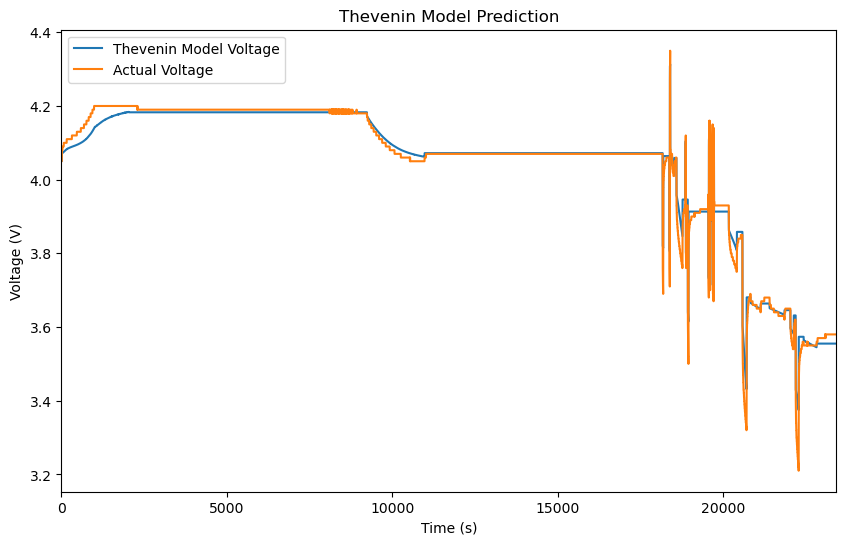

In [12]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, V_pred, label='Thevenin Model Voltage')
ax.plot(t, V_actual, label='Actual Voltage')
ax.legend()
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Thevenin Model Prediction')
plt.show()

## Error Analysis

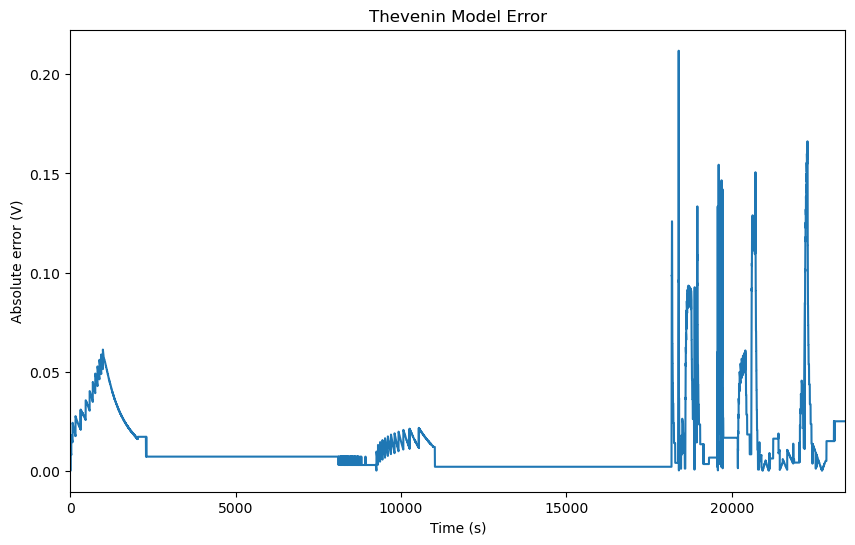

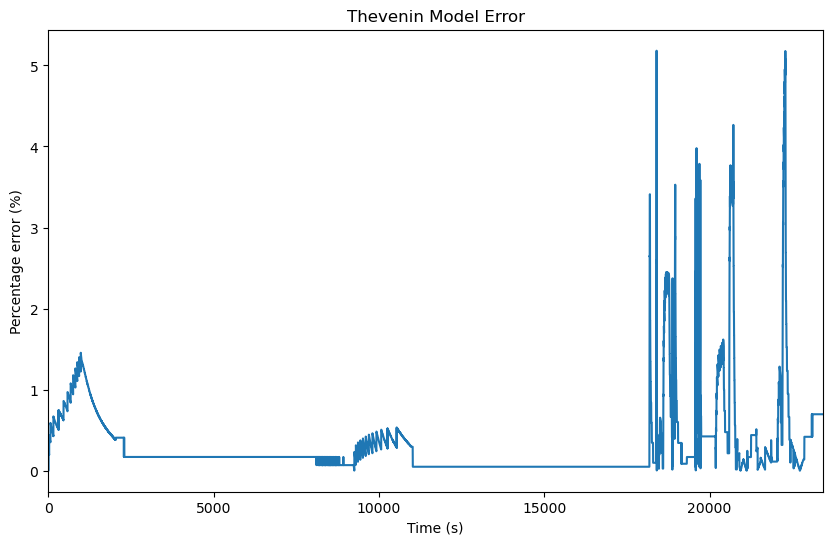

In [14]:
error = np.abs(V_pred - V_actual)
error_pct = np.abs((V_pred - V_actual) / V_actual)

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, error)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Absolute error (V)')
ax.set_title('Thevenin Model Error')
plt.show()

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, error_pct*100)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Percentage error (%)')
ax.set_title('Thevenin Model Error')
plt.show()


In [8]:
max_err = np.max(error)
max_idx = np.argmax(error)
t_max_err = t[max_idx]

print("Maximum absolute error is {:.4f} V, at t = {} s".format(max_err, t_max_err))

max_err = np.max(error_pct)
max_idx = np.argmax(error_pct)
t_max_err = t[max_idx]

print("Maximum percentage error is {:.4f}%, at t = {} s".format(max_err*100, t_max_err))

Maximum absolute error is 0.2119 V, at t = 18395 s
Maximum percentage error is 5.1812%, at t = 18395 s


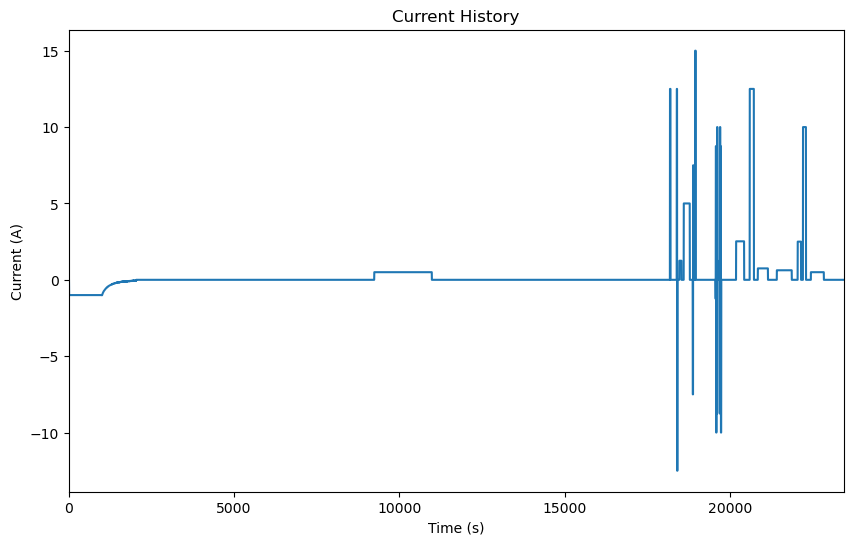

In [13]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, I)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')
ax.set_title('Current History')
plt.show()

Answer to 3.2:

When the current changes by a large amount quickly, the discrete time integration of z(t) becomes inaccurate. This gives an inaccurate estimation of the state of charge and results in a large error in Voltage.